In [1]:
#각종 라이브러리를 임포트 해줍시다. 

%matplotlib inline
import torchvision
import torchvision.datasets as dset
import torchvision.transforms as transforms
from torch.utils.data import DataLoader,Dataset
import matplotlib.pyplot as plt
import torchvision.utils
import numpy as np
import random
from PIL import Image
import torch
from torch.autograd import Variable
import PIL.ImageOps    
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'
import glob
from PIL import ExifTags
import shutil
from torch.optim.lr_scheduler import ReduceLROnPlateau
import copy

In [2]:
class Config():
    training_dir = "D:/training/"
    testing_dir = "D:/testing/"
    validation_dir = "D:/validation/"
    train_batch_size = 64
    train_number_epochs = 10

In [3]:
#각종 사용할 함수를 세팅합니다.

def imshow(img,text=None,should_save=False):
    npimg = img.numpy()
    plt.axis("off")
    if text:
        plt.text(75, 8, text, style='italic',fontweight='bold',
            bbox={'facecolor':'white', 'alpha':0.8, 'pad':10})
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()    

def show_plot(iteration,loss):
    plt.plot(iteration,loss)
    plt.show()

In [4]:
# # 경로 지정
# folder_path = 'D:/Face_data'
# testing_folder = 'D:/testing'
# training_folder = 'D:/training'
# validation_folder = "D:/validation"
# val_lis = []

# test_samples = 619 # testing 폴더 갯수
# val_sampes = 309 # validation 폴더 갯수
# random.seed(10) # 랜덤시드 고정

# folders = next(os.walk(folder_path))[1] # D 드라이브에 있는 폴더를 가져오기
# test_folders = random.sample(folders, test_samples) # testing 폴더를 랜덤으로 뽑기
# for folder in folders:
#     if folder not in test_folders:
#         val_lis.append(folder)
# val_folders = random.sample(val_lis, val_sampes) # validation 폴더를 랜덤으로 뽑기

# # 폴더 생성
# os.makedirs(training_folder, exist_ok=True)
# os.makedirs(testing_folder, exist_ok=True)
# os.makedirs(validation_folder, exist_ok=True)

# # testing 폴더에 복사
# for folder in test_folders:
#     source_path = os.path.join(folder_path, folder)
#     destination_path = os.path.join(testing_folder, folder)
#     shutil.copytree(source_path, destination_path)

# # validation 폴더에 복사
# for folder in val_folders:
#     source_path = os.path.join(folder_path, folder)
#     destination_path = os.path.join(validation_folder, folder)
#     shutil.copytree(source_path, destination_path)

# # 나머지는 training 폴더에 복사
# for folder in folders:
#     if folder not in test_folders and folder not in val_folders:
#         source_path = os.path.join(folder_path, folder)
#         destination_path = os.path.join(training_folder, folder)
#         shutil.copytree(source_path, destination_path)

In [5]:
# path = r"D:\training\**"
# rot_img = []
# for f in glob.glob(path, recursive=True):
#     try:
#         img = Image.open(f)
#         exif_data = img._getexif()
#         if exif_data[274] != 1:
#             print(f, exif_data[274])
#             rot_img.append(img)
#     except:
        # pass

In [6]:
class SiameseNetworkDataset(Dataset):
    
    def __init__(self,imageFolderDataset,transform=None,should_invert=True):
        self.imageFolderDataset = imageFolderDataset    
        self.transform = transform
        self.should_invert = should_invert

    def rotate(self, img):
        try:
            if img._getexif()[274] not in [1, 2]:
                orientation = img._getexif()[274]
                
                if orientation == 2:
                    img = img.transpose(Image.FLIP_LEFT_RIGHT)

                elif orientation == 3:
                    img = img.rotate(180)

                elif orientation == 4:
                    img = img.rotate(180).transpose(Image.FLIP_LEFT_RIGHT)

                elif orientation == 5:
                    img = img.rotate(-90, expand=True).transpose(Image.FLIP_LEFT_RIGHT)

                elif orientation == 6:
                    img = img.rotate(-90, expand=True)

                elif orientation == 7:
                    img = img.rotate(90, expand=True).transpose(Image.FLIP_LEFT_RIGHT)
            
            return img
        except:
            return img
        
    def __getitem__(self,index):
        img0_tuple = random.choice(self.imageFolderDataset.imgs)
        #we need to make sure approx 50% of images are in the same class
        should_get_same_class = random.randint(0,1) 
        if should_get_same_class:
            while True:
                #keep looping till the same class image is found
                img1_tuple = random.choice(self.imageFolderDataset.imgs) 
                if img0_tuple[1]==img1_tuple[1]:
                    break
        else:
            while True:
                #keep looping till a different class image is found
                
                img1_tuple = random.choice(self.imageFolderDataset.imgs) 
                if img0_tuple[1] !=img1_tuple[1]:
                    break

        img0 = Image.open(img0_tuple[0])
        img1 = Image.open(img1_tuple[0])

        if img0._getexif() not in [1, 2]:
            img0 = self.rotate(img0)
        
        if img1._getexif() not in [1, 2]:
            img1 = self.rotate(img1)

        img0 = img0.convert("L")
        img1 = img1.convert("L")
        
        if self.should_invert:
            img0 = PIL.ImageOps.invert(img0)
            img1 = PIL.ImageOps.invert(img1)

        if self.transform is not None:
            img0 = self.transform(img0)
            img1 = self.transform(img1)

        return img0, img1 , torch.from_numpy(np.array([int(img1_tuple[1]!=img0_tuple[1])],dtype=np.float32))
    
    def __len__(self):
        return len(self.imageFolderDataset.imgs)

In [7]:
#training_dir 경로 안의 모든 파일을 폴더명과 함께 튜플로 저장
folder_dataset = dset.ImageFolder(root=Config.training_dir)

In [8]:
siamese_dataset = SiameseNetworkDataset(imageFolderDataset=folder_dataset,
                                        transform=transforms.Compose([transforms.Resize((100,100)),
                                                                      transforms.ToTensor()]),
                                        should_invert=False)

In [9]:
siamese_dataset[0]

(tensor([[[0.7098, 0.7098, 0.7098,  ..., 0.6627, 0.6627, 0.6627],
          [0.7098, 0.7098, 0.7098,  ..., 0.6627, 0.6627, 0.6627],
          [0.7098, 0.7098, 0.7098,  ..., 0.6667, 0.6667, 0.6627],
          ...,
          [0.4627, 0.4784, 0.4784,  ..., 0.4275, 0.4549, 0.4431],
          [0.4784, 0.4902, 0.4745,  ..., 0.4196, 0.4235, 0.4588],
          [0.5176, 0.4667, 0.4784,  ..., 0.4118, 0.4000, 0.4314]]]),
 tensor([[[0.1529, 0.1294, 0.1255,  ..., 0.6039, 0.6039, 0.6039],
          [0.1569, 0.1294, 0.1333,  ..., 0.6039, 0.6039, 0.6039],
          [0.1490, 0.1373, 0.1490,  ..., 0.6039, 0.6039, 0.6039],
          ...,
          [0.4784, 0.4706, 0.4784,  ..., 0.6706, 0.6588, 0.6549],
          [0.4627, 0.4784, 0.4784,  ..., 0.6706, 0.6588, 0.6588],
          [0.4824, 0.4706, 0.4471,  ..., 0.6706, 0.6667, 0.6706]]]),
 tensor([0.]))

In [10]:
# # 미니배치 생성기
# vis_dataloader = DataLoader(siamese_dataset,
#                         shuffle=True,
#                         num_workers=0,
#                         batch_size=8)
# # 미니배치 세트 생성
# dataiter = iter(vis_dataloader)

In [11]:
# dataiter

In [12]:
# example_batch = next(dataiter)

In [13]:
# concatenated = torch.cat((example_batch[0],example_batch[1]),0)
# imshow(torchvision.utils.make_grid(concatenated))
# print(example_batch[2].numpy())

In [14]:
# torchvision.utils.make_grid(concatenated).shape

In [15]:
# SiameseNetwork
class SiameseNetwork(nn.Module):
    def __init__(self):
        super(SiameseNetwork, self).__init__()
        self.cnn1 = nn.Sequential(
            nn.ReflectionPad2d(1),
            nn.Conv2d(1, 8, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(8),
            
            nn.ReflectionPad2d(1),
            nn.Conv2d(8, 8, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(8),

            # nn.ReflectionPad2d(1),
            # nn.Conv2d(8, 8, kernel_size=3),
            # nn.ReLU(inplace=True),
            # nn.BatchNorm2d(8),
            
            nn.Dropout(0.5)
        )

        self.fc1 = nn.Sequential(
            nn.Linear(8*100*100, 512),
            nn.ReLU(inplace=True),

            nn.Linear(512, 216),
            nn.ReLU(inplace=True),

            nn.Linear(216, 5))

    def forward_once(self, x):
        output = self.cnn1(x)
        output = output.view(output.size()[0], -1)
        output = self.fc1(output)
        return output

    def forward(self, input1, input2):
        output1 = self.forward_once(input1)
        output2 = self.forward_once(input2)
        return output1, output2

In [16]:
class ContrastiveLoss(torch.nn.Module):

    def __init__(self, margin=2.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, output1, output2, label):
        euclidean_distance = F.pairwise_distance(output1, output2, keepdim = True)
        loss_contrastive = torch.mean((1-label) * torch.pow(euclidean_distance, 2) +
                                      (label) * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2))

        return loss_contrastive

In [17]:
# Early Stopping을 위해 validation loss를 계산하는 함수
def calculate_validation_loss(model, dataloader, criterion):
    total_loss = 0.0
    total_samples = 0

    model.eval()  # 모델을 평가 모드로 설정

    with torch.no_grad():
        for data in dataloader:
            inputs1, inputs2, labels = data
            inputs1 = inputs1.cuda()
            inputs2 = inputs2.cuda()
            labels = labels.cuda()

            outputs1, outputs2 = model(inputs1, inputs2)
            loss = criterion(outputs1, outputs2, labels)

            total_loss += loss.item() * inputs1.size(0)
            total_samples += inputs1.size(0)

    average_loss = total_loss / total_samples

    return average_loss

In [18]:
train_dataloader = DataLoader(siamese_dataset, shuffle=True, num_workers=0, 
                              batch_size=Config.train_batch_size)

In [19]:
# validation 데이터셋
folder_dataset_val = dset.ImageFolder(root=Config.validation_dir)
siamese_dataset_val = SiameseNetworkDataset(imageFolderDataset=folder_dataset_val,
                                            transform=transforms.Compose([transforms.Resize((100, 100)),
                                                                         transforms.ToTensor()]),
                                            should_invert=False)
validation_dataloader = DataLoader(siamese_dataset_val, num_workers=0, batch_size=16)

In [20]:
net = SiameseNetwork().cuda()
criterion = ContrastiveLoss()

In [21]:
counter = []
train_loss_history = []
val_loss_history = []
iteration_number= 0

Epoch number 1
 Current loss 1.463916540145874

Epoch number 1
 Current loss 0.6318185925483704

Epoch number 1
 Current loss 0.4365839958190918

Epoch number 1
 Current loss 0.4461438059806824

Epoch number 1
 Current loss 0.43991443514823914

Epoch number 1
 Current loss 0.39442771673202515

Epoch number 1
 Current loss 0.37822049856185913

Epoch number 2
 Current loss 0.38279277086257935

Epoch number 2
 Current loss 0.45479312539100647

Epoch number 2
 Current loss 0.32670482993125916

Epoch number 2
 Current loss 0.2594236135482788

Epoch number 2
 Current loss 0.23645025491714478

Epoch number 2
 Current loss 0.3273043632507324

Epoch number 2
 Current loss 0.2941705286502838

Epoch number 3
 Current loss 0.317592978477478

Epoch number 3
 Current loss 0.29868870973587036

Epoch number 3
 Current loss 0.21380668878555298

Epoch number 3
 Current loss 0.2142859846353531

Epoch number 3
 Current loss 0.21736577153205872

Epoch number 3
 Current loss 0.26917165517807007

Epoch numbe

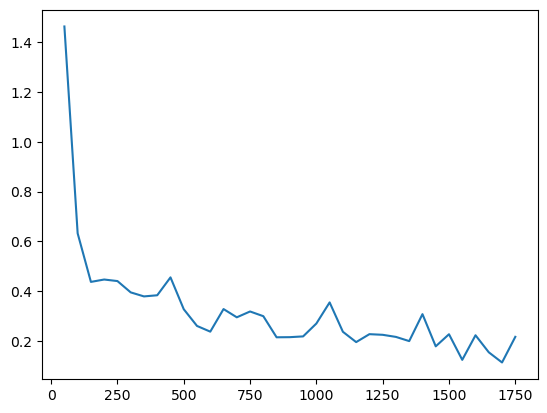

In [22]:
# Early Stopping과 Model Checkpoint를 위한 변수 설정
patience = 5  # 검증 손실이 감소하지 않아도 참을 수 있는 epoch 수
early_stopping_counter = 0
best_loss = float('inf')
best_model = None
best_model_state = None
checkpoint_path = './model/model_checkpoint.pt'



# Optimizer와 Scheduler 설정
optimizer = optim.Adam(net.parameters(), lr=0.0005)
scheduler = ReduceLROnPlateau(optimizer, patience=patience, factor=0.1, verbose=True)

# 학습
for epoch in range(0, Config.train_number_epochs):
    for i, data in enumerate(train_dataloader, 0):
        img0, img1, label = data
        img0, img1, label = img0.cuda(), img1.cuda(), label.cuda()
        optimizer.zero_grad()
        output1,output2 = net(img0, img1)
        loss_contrastive = criterion(output1, output2, label)
        loss_contrastive.backward()
        optimizer.step()
        if i % 50 == 0 :
            print("Epoch number {}\n Current loss {}\n".format(epoch+1, loss_contrastive.item()))
            iteration_number += 50
            counter.append(iteration_number)
            train_loss_history.append(loss_contrastive.item())
        
    # 검증 데이터로 성능 평가
    val_loss = calculate_validation_loss(net, validation_dataloader, criterion)

    # Save the validation loss
    val_loss_history.append(val_loss)

    # 현재 검증 손실이 최저 손실보다 낮으면 모델 저장
    if val_loss < best_loss:
        best_loss = val_loss
        best_model_state = copy.deepcopy(net.state_dict())
        # Save checkpoint
        torch.save(best_model_state, checkpoint_path)
        print('Saved model')
        
    # 검증 손실이 더 좋아지지 않으면 카운터 증가
    if val_loss >= best_loss:
        early_stopping_counter += 1
    else:
        early_stopping_counter = 0
        
    # 학습 조기 종료 조건 확인
    if early_stopping_counter >= patience:
        print("Early Stopping: Training stopped due to no improvement in validation loss.")
        break

    # Learning Rate 조정
    scheduler.step(val_loss)
    
    if early_stopping_counter >= patience:
        break

# Plot the training and validation losses
plt.plot(counter, train_loss_history, label='Training Loss')
plt.plot(range(len(val_loss)), val_loss_history, label='Validation Loss')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.legend()
plt.show()

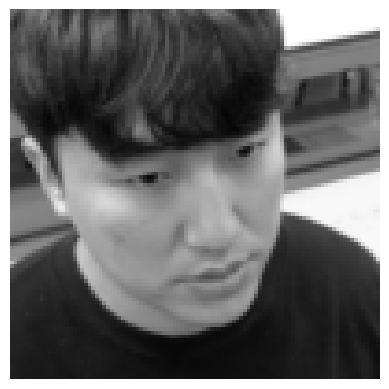

In [35]:
folder_dataset_test = dset.ImageFolder(root=Config.testing_dir)
siamese_dataset = SiameseNetworkDataset(imageFolderDataset=folder_dataset_test,
                                        transform=transforms.Compose([transforms.Resize((100,100)),
                                                                      transforms.ToTensor()]), 
                                        should_invert=False)

test_dataloader = DataLoader(siamese_dataset, num_workers=0, batch_size=1, shuffle=True)
dataiter = iter(test_dataloader)
x0, _, _ = next(dataiter)
imshow(torchvision.utils.make_grid(x0))

In [36]:
# Load the best model
if best_model is not None:
    net.load_state_dict(best_model)

# Load the best model from checkpoint
checkpoint = torch.load('./model/model_checkpoint.pt')
net.load_state_dict(checkpoint)

<All keys matched successfully>

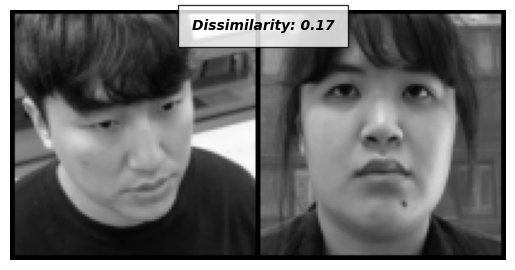

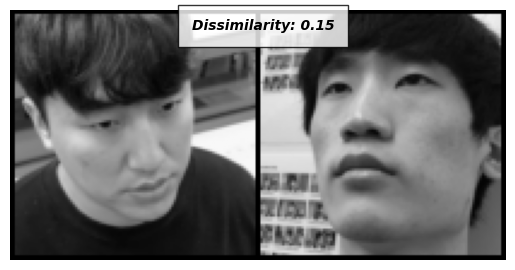

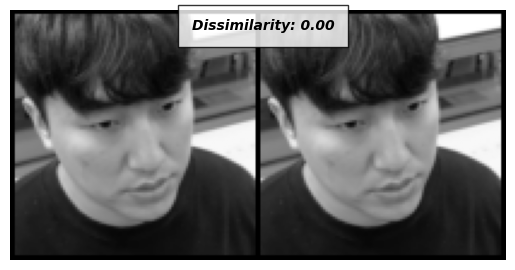

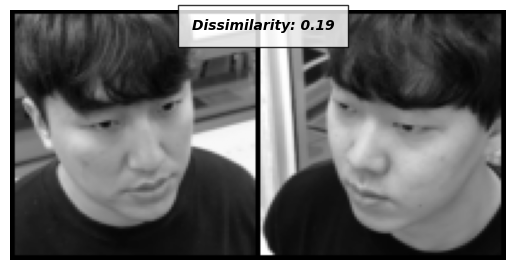

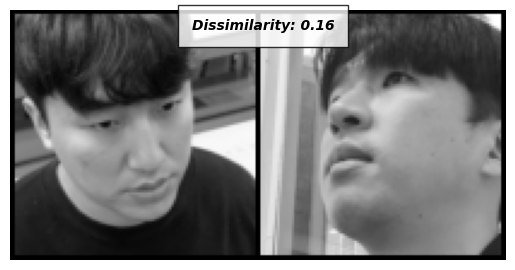

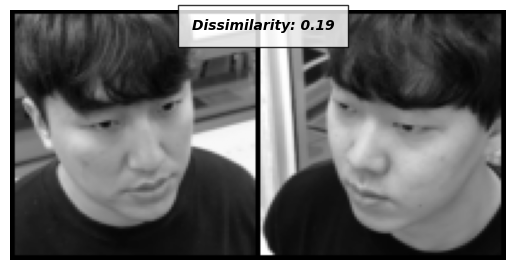

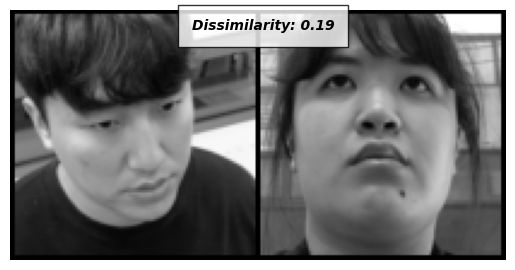

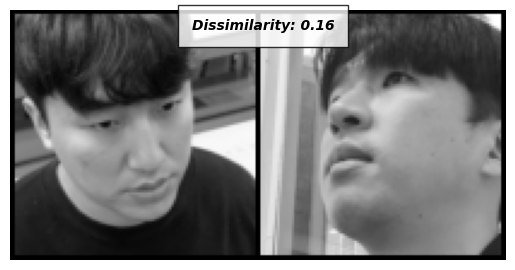

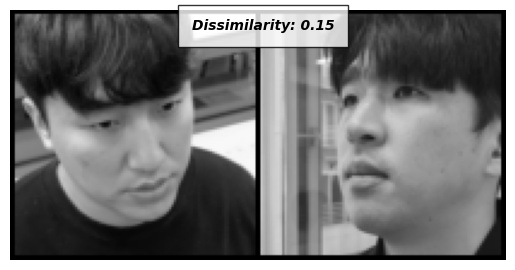

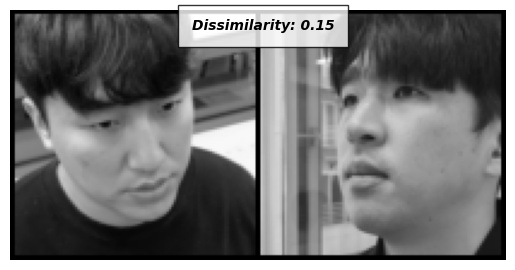

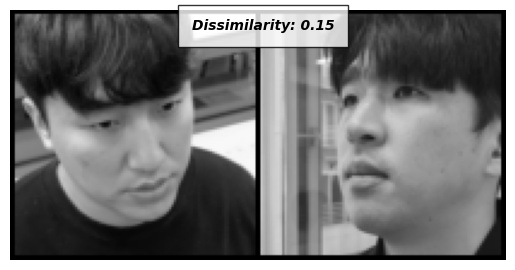

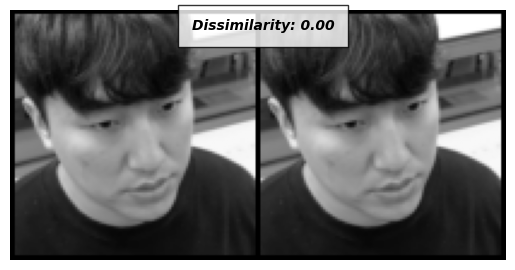

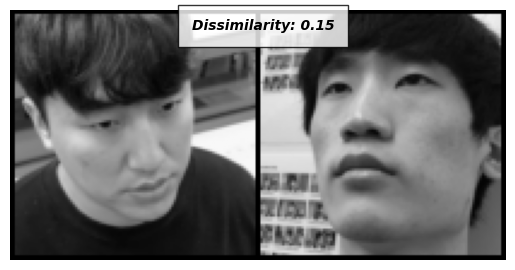

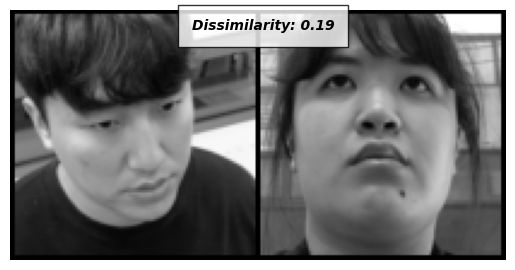

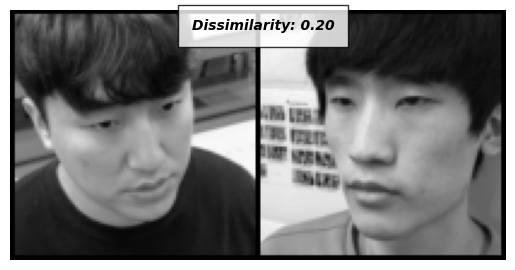

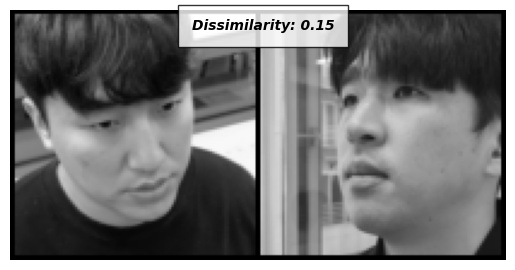

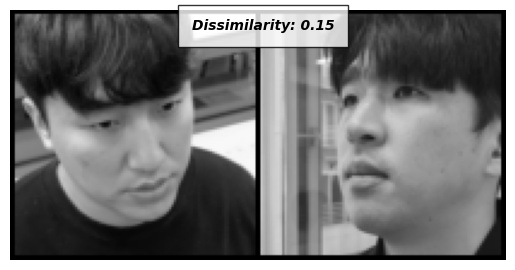

In [37]:
for i in range(len(dataiter) - 1):
    _, x1, _ = next(dataiter)
    concatenated = torch.cat((x0,x1), 0)
    
    output1, output2 = net(Variable(x0).cuda(), Variable(x1).cuda())
    euclidean_distance = F.pairwise_distance(output1, output2)
    if euclidean_distance < 0.2:
        imshow(torchvision.utils.make_grid(concatenated), 'Dissimilarity: {:.2f}'.format(euclidean_distance.item()))